# AirBnB Customer Segmentation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import os

In [490]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [492]:
path = '/Users/admin/Documents/BC#2/Labs/Week08/AirBnB-customer-segmentation/'

In [493]:
df = pd.read_csv(path + "AB_NYC_2019.csv")

In [494]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [495]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [496]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

The columns `last_review` and `reviews_per_month` are the ones presenting the highest number of missing values (10052). We can check whether those missing `last_review` are also missing `reviews_per_month`: if the place did not receive any review, the larst review and the reviews_per_month are centainly missing. 
Secondly, `host_name` and `name` present a few missing values (21 and 16 respebctively) and also those are removed. 

#### Missing values

In [497]:
# Drop NaNs in `host_name` , `name` , last_review and reviews_per_month
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)

In [498]:
# Convert revelant categorical columns into integers
df['neighbourhood_group_int'] = df['neighbourhood_group'].map({'Brooklyn':1, 'Manhattan':2, 'Queens':3, 'Staten Island':4, 'Bronx':5})
df['room_type_int'] = df['room_type'].map({'Private room':1, 'Entire home/apt':2, 'Shared room':3})
    

#### Outliers 

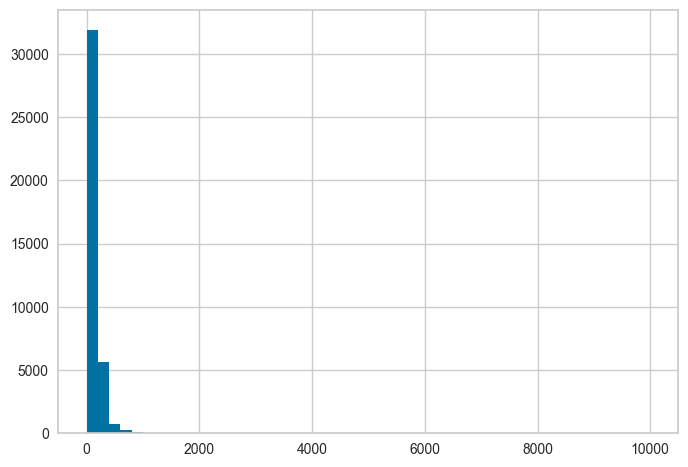

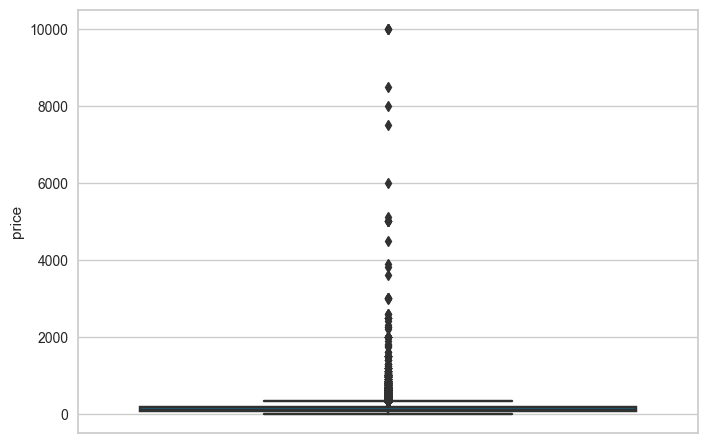

In [499]:
# Price
plt.hist(data = df, x = 'price', bins=50)
plt.show()
sns.boxplot(data = df,
            y = 'price')
plt.show()

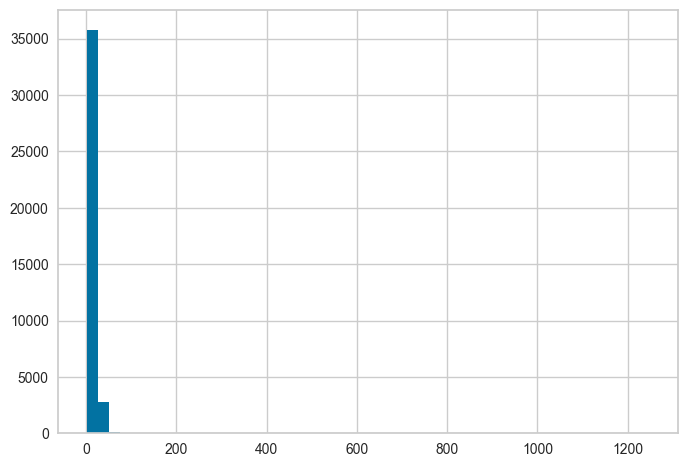

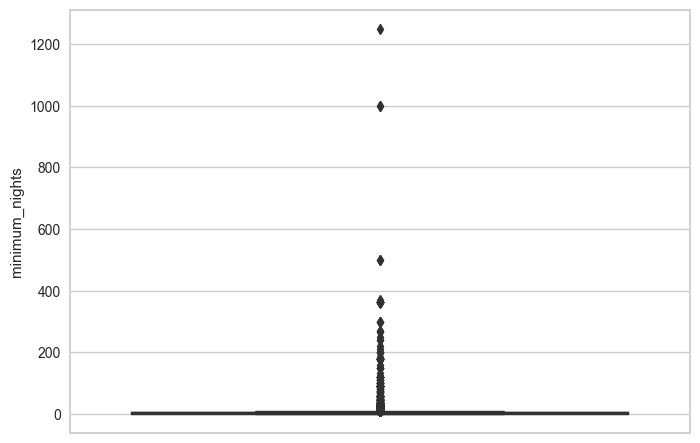

In [500]:
# minimum_nights
plt.hist(data = df, x = 'minimum_nights', bins=50)
plt.show()
sns.boxplot(data = df,
            y = 'minimum_nights')
plt.show()


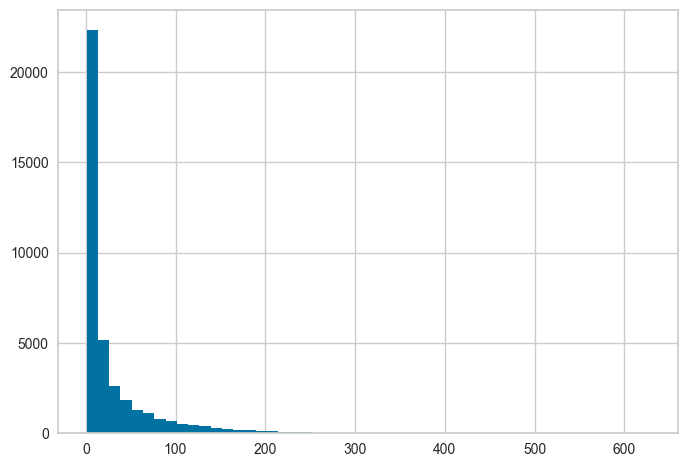

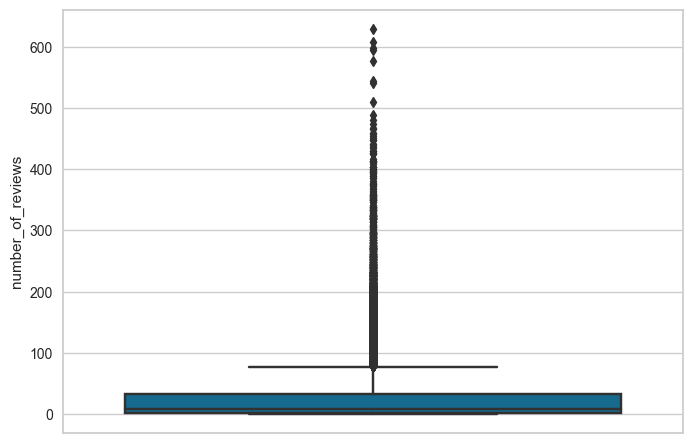

In [501]:
# number_of_reviews
plt.hist(data = df, x = 'number_of_reviews', bins=50)
plt.show()
sns.boxplot(data = df,
            y = 'number_of_reviews')
plt.show()

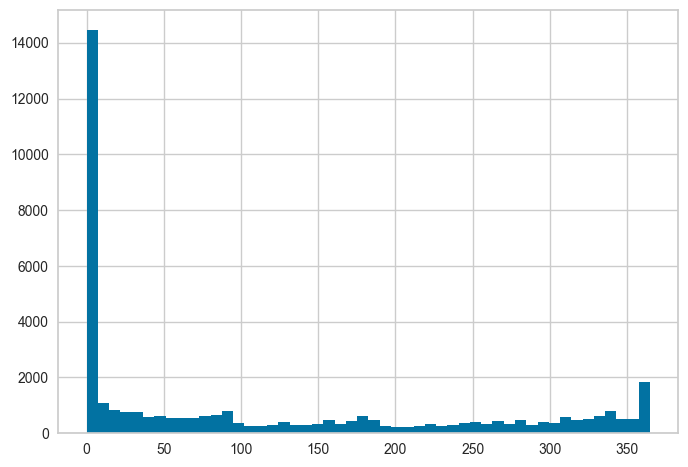

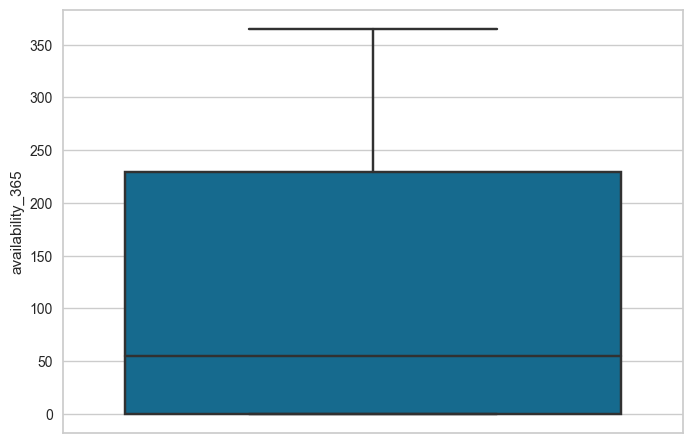

In [502]:
# availability_365: it's Okay!!
plt.hist(data = df, x = 'availability_365', bins=50)
plt.show()
sns.boxplot(data = df,
            y = 'availability_365')
plt.show()

In [503]:
# Remove ouliers: outliers have a significant impact on clustering. Hence it is better to identify and remove outliers before applying K-means clustering algorithm.

# price
df = remove_outlier(df, 'price')              # from 38821 --> 36744 = 2077 removed
# availability_365
df = remove_outlier(df, 'availability_365')   # from 36744 --> 36744 = 0 removed
# minimum_nights
df = remove_outlier(df, 'minimum_nights')     # from 36744 --> 32474 = 4270 removed
# number_of_reviews
df = remove_outlier(df, 'number_of_reviews')  # from 32474 --> 29164 = 3310 removed
# calculated_host_listings_count
df = remove_outlier(df, 'calculated_host_listings_count')  # from 29164 --> 26286 = 2878 removed
    
# drop if price == 0, because it is impossible
df.drop(df[df.price < 10].index, inplace=True)

    

(array([1295., 6155., 6187., 3448., 3352., 1904., 1824., 1054.,  455.,
         610.]),
 array([ 10. ,  41.1,  72.2, 103.3, 134.4, 165.5, 196.6, 227.7, 258.8,
        289.9, 321. ]),
 <BarContainer object of 10 artists>)

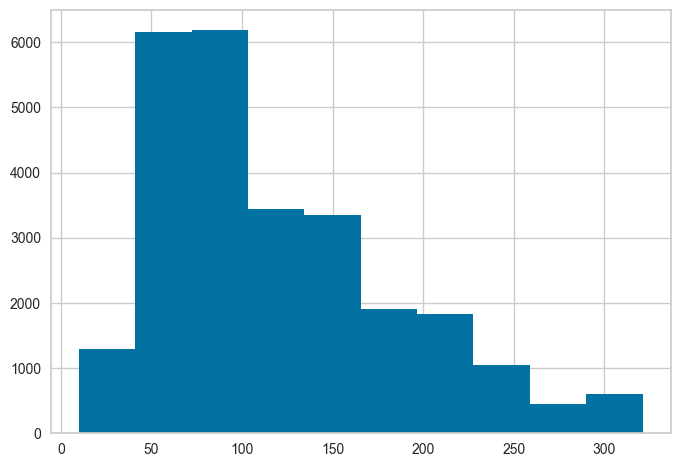

In [504]:
#### Normalize skewed data 
plt.hist(df.price)

In [511]:
# Mean normalization of price: New value = (value – mean) / (standard deviation)
df['price_transf'] = np.log(df['price'])
df['minimum_nights_transf'] = np.log(df['minimum_nights'])
df['number_of_reviews_transf'] = np.log(df['number_of_reviews'])

(array([  13.,   18.,   96., 1121., 2904., 5339., 5072., 5649., 3950.,
        2122.]),
 array([2.30258509, 2.6494707 , 2.9963563 , 3.3432419 , 3.69012751,
        4.03701311, 4.38389871, 4.73078431, 5.07766992, 5.42455552,
        5.77144112]),
 <BarContainer object of 10 artists>)

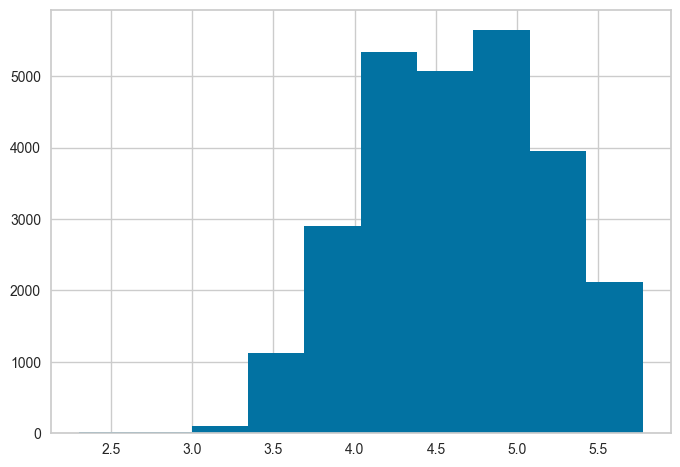

In [509]:
plt.hist(df.price_transf)

(array([6914., 7871., 5370.,    0., 2254., 2028.,    0.,  518., 1238.,
          91.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

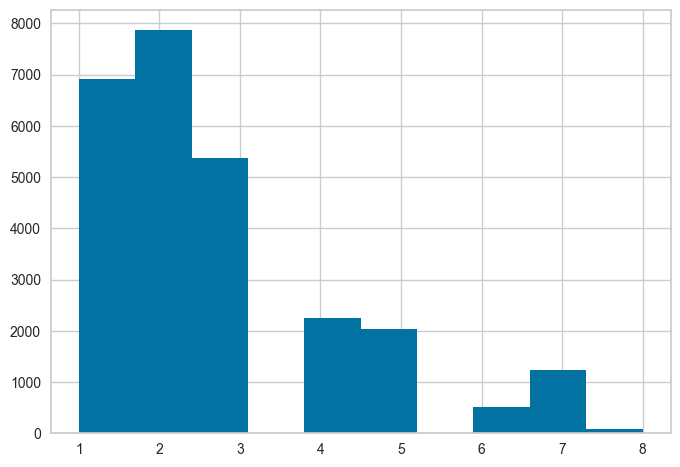

In [507]:
plt.hist(df.minimum_nights)

(array([6914.,    0.,    0., 7871.,    0., 5370., 2254., 2028.,  518.,
        1329.]),
 array([0.        , 0.20794415, 0.41588831, 0.62383246, 0.83177662,
        1.03972077, 1.24766493, 1.45560908, 1.66355323, 1.87149739,
        2.07944154]),
 <BarContainer object of 10 artists>)

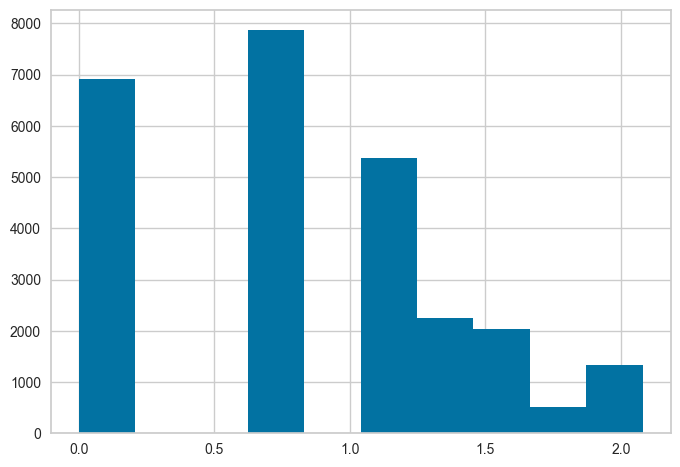

In [510]:
plt.hist(df.minimum_nights_transf)

(array([3735., 2552., 1862., 3591., 2390., 2540., 2791., 2420., 2317.,
        2086.]),
 array([0.        , 0.44998097, 0.89996193, 1.3499429 , 1.79992387,
        2.24990484, 2.6998858 , 3.14986677, 3.59984774, 4.0498287 ,
        4.49980967]),
 <BarContainer object of 10 artists>)

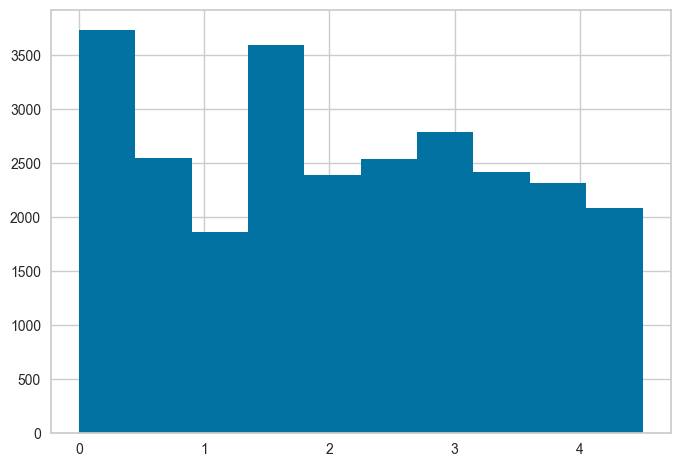

In [512]:
plt.hist(df.number_of_reviews_transf)

In [513]:
#Get a count by borough
neighbourhood_group_count = df.groupby('neighbourhood_group').agg('count').reset_index()
neighbourhood_group_count

,neighbourhood_group,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf
0,Bronx,623,623,623,623,623,623,623,623,623,...,623,623,623,623,623,623,623,623,623,623
1,Brooklyn,11657,11657,11657,11657,11657,11657,11657,11657,11657,...,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657
2,Manhattan,10744,10744,10744,10744,10744,10744,10744,10744,10744,...,10744,10744,10744,10744,10744,10744,10744,10744,10744,10744
3,Queens,3044,3044,3044,3044,3044,3044,3044,3044,3044,...,3044,3044,3044,3044,3044,3044,3044,3044,3044,3044
4,Staten Island,216,216,216,216,216,216,216,216,216,...,216,216,216,216,216,216,216,216,216,216


<Axes: xlabel='neighbourhood_group', ylabel='count'>

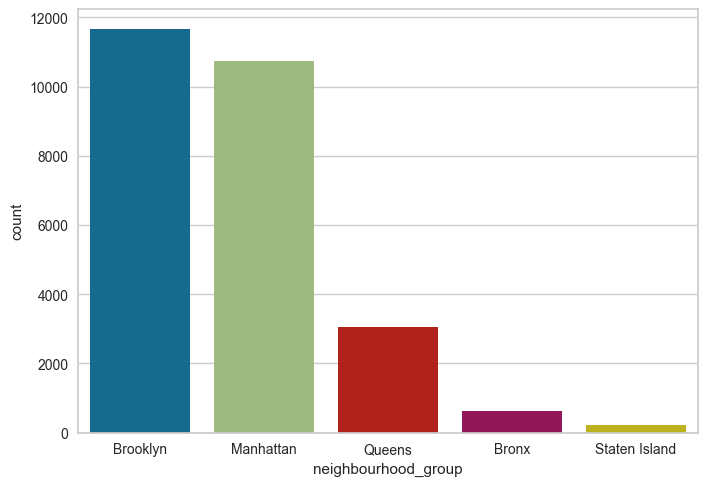

In [514]:
# Plot number of  AirBnB in each neighbourhood_group
sns.countplot(data=df, x='neighbourhood_group', order=df['neighbourhood_group'].value_counts().index)

<Axes: xlabel='room_type', ylabel='count'>

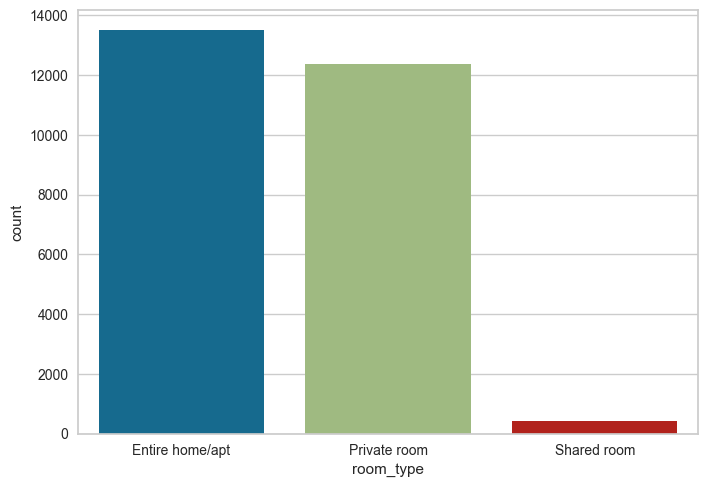

In [515]:
# Plot number of AirBnB by room_type
sns.countplot(data=df, x='room_type', order=df['room_type'].value_counts().index)


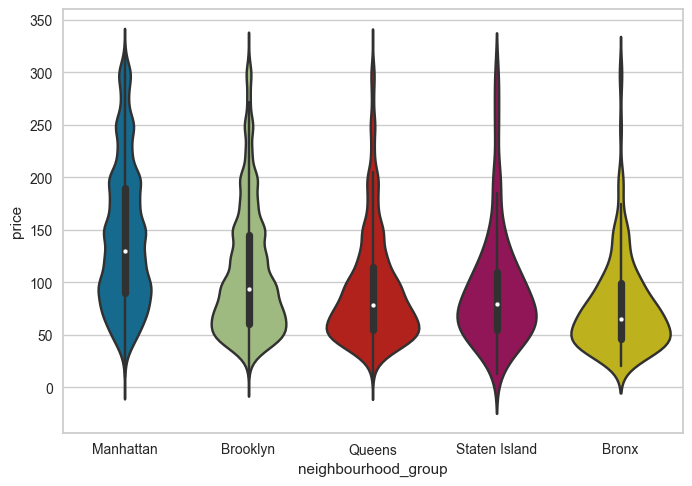

In [516]:
# Plot price by neighbourhood_group
sns.violinplot(data=df, x='neighbourhood_group', y='price')
plt.show()

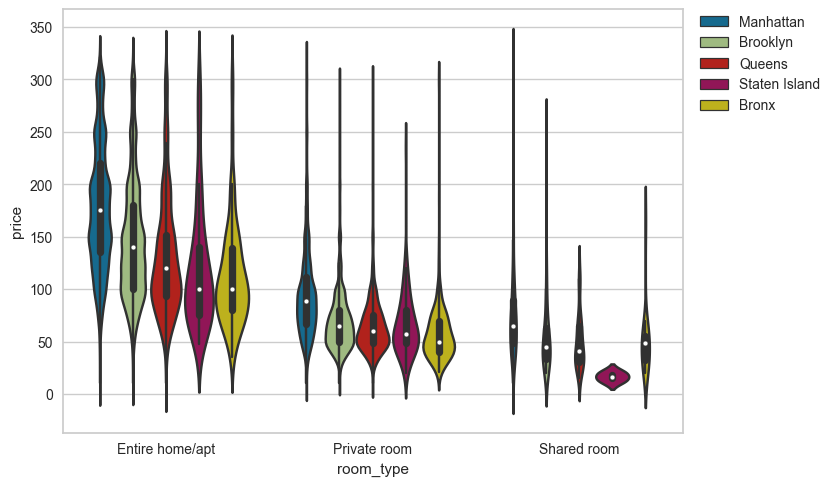

In [517]:
# Plot price by neighbourhood_group
sns.violinplot(data=df, x='room_type', y='price', hue = 'neighbourhood_group')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


In [420]:
# Plot neighbourhood_groupin NYC map



#### Keep only numerical data

In [520]:
# Select columns with numerical values
df_num = df.select_dtypes("number").copy()


df_num.corr().style.background_gradient(cmap='coolwarm')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf
id,1.000000,0.543617,-0.012594,0.126977,-0.034977,-0.146482,-0.199989,0.463271,0.086941,0.063387,0.091579,-0.040328,-0.053863,-0.140859,-0.174335
host_id,0.543617,1.000000,0.024359,0.177506,-0.040461,-0.159542,-0.035021,0.381372,0.084396,0.185389,0.183147,-0.043771,-0.068701,-0.171825,-0.023580
latitude,-0.012594,0.024359,1.000000,0.103476,0.041120,-0.004604,-0.011646,-0.015440,-0.033201,-0.037206,0.531700,-0.025510,0.043847,-0.013136,-0.009710
longitude,0.126977,0.177506,0.103476,1.000000,-0.289348,-0.104679,0.061545,0.141636,0.118436,0.168260,0.283903,-0.125979,-0.309268,-0.114016,0.064641
price,-0.034977,-0.040461,0.041120,-0.289348,1.000000,0.085338,0.007400,-0.007717,-0.147020,0.043791,-0.027195,0.534787,0.955934,0.121634,0.017858
minimum_nights,-0.146482,-0.159542,-0.004604,-0.104679,0.085338,1.000000,-0.087254,-0.224540,-0.087368,-0.066502,-0.079402,0.120347,0.092373,0.952083,-0.090370
number_of_reviews,-0.199989,-0.035021,-0.011646,0.061545,0.007400,-0.087254,1.000000,0.476419,0.124561,0.268684,0.040224,0.020014,0.018596,-0.065430,0.858407
reviews_per_month,0.463271,0.381372,-0.015440,0.141636,-0.007717,-0.224540,0.476419,1.000000,0.138420,0.241451,0.103467,0.002273,-0.011532,-0.224553,0.496179
calculated_host_listings_count,0.086941,0.084396,-0.033201,0.118436,-0.147020,-0.087368,0.124561,0.138420,1.000000,0.218718,0.035960,-0.195254,-0.161325,-0.096045,0.135425
availability_365,0.063387,0.185389,-0.037206,0.168260,0.043791,-0.066502,0.268684,0.241451,0.218718,1.000000,0.132706,-0.036775,0.030599,-0.067988,0.274105


In [521]:
df_num.columns

Index(['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'neighbourhood_group_int', 'room_type_int', 'price_transf',
       'minimum_nights_transf', 'number_of_reviews_transf'],
      dtype='object')

In [522]:
# drop unnecessary columns
df_num.drop(columns=['host_id', 'id', 'latitude', 'longitude', 'reviews_per_month'], inplace = True)

### Selecting number of clusters for k-means classification

#### The elbow method

In [523]:
# first we have to get the inertia values for a variety of different cluster numbers
inertia_dict = {
    'clusters': [],
    'inertia': []
}

for i in range(2,11): # we choose 2 as the minimum number of clusters. It doesnt really make sense to have 1 cluster
    scaler = StandardScaler()
    cluster = KMeans(n_clusters=i) # here we set the number of clusters for every iteration
    pipe = make_pipeline(scaler, cluster)
    pipe.fit(df_num)
    inertia_dict['clusters'].append(i)
    inertia_dict['inertia'].append(pipe['kmeans'].inertia_)

inertia_df = pd.DataFrame(inertia_dict)

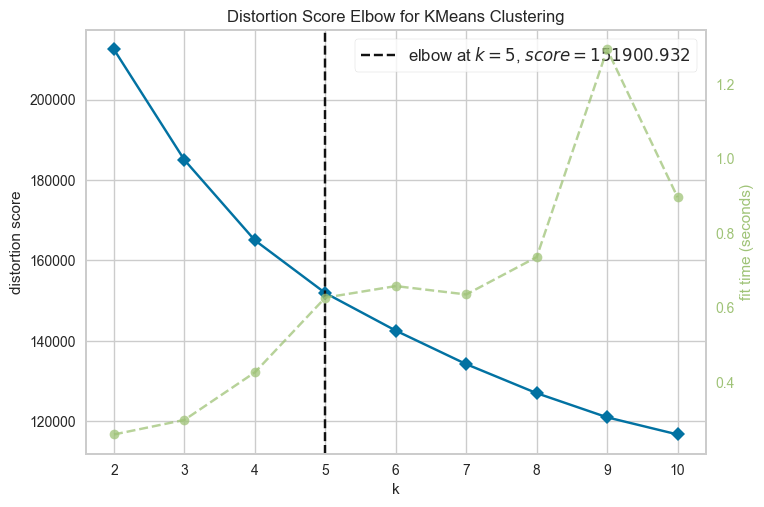

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [524]:
scaler = StandardScaler()
cluster = KElbowVisualizer(KMeans(n_init=10))
pipe = make_pipeline(scaler, cluster)

pipe.fit(df_num)
pipe[1].show()

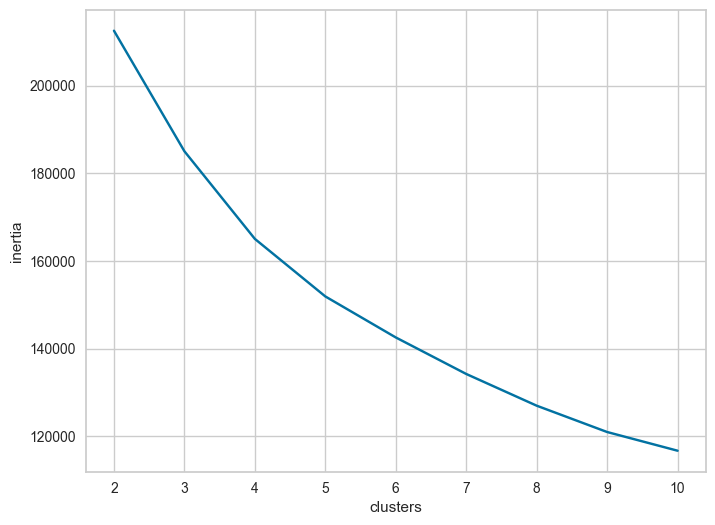

In [525]:
plt.figure(figsize=(8, 6))
g = sns.lineplot(data=inertia_df, x='clusters', y='inertia')
plt.show()

The elbow method suggests 5 clusters.

#### Clustering the data

In [529]:
# Pipeline :
# 1. scale data
# 2. create clusters

scaler = StandardScaler()
cluster = KMeans(n_clusters=5)
pipe = make_pipeline(scaler, cluster)
pipe.fit(df_num)

values = pipe[:1].transform(df_num)

df["clusters"] = pipe["kmeans"].labels_

df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,2019-05-21,0.38,2,355,2,2,5.416100,0.000000,3.806662,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,2019-06-22,0.59,1,129,2,2,5.298317,1.098612,4.304065,0
9,5295,Beautiful 1br on Upper West Side,7702,Lena,Manhattan,Upper West Side,40.80316,-73.96545,Entire home/apt,135,...,2019-06-22,0.43,1,6,2,2,4.905275,1.609438,3.970292,0
17,7726,Hip Historic Brownstone Apartment with Backyard,20950,Adam And Charity,Brooklyn,Crown Heights,40.67592,-73.94694,Entire home/apt,99,...,2019-06-22,4.44,1,21,1,2,4.595120,1.098612,3.970292,0
18,7801,Sweet and Spacious Brooklyn Loft,21207,Chaya,Brooklyn,Williamsburg,40.71842,-73.95718,Entire home/apt,299,...,2011-12-28,0.07,1,0,1,2,5.700444,1.098612,2.197225,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38814,36411407,Brand new 1 bedroom steps from Soho!,33917435,Mike,Manhattan,Lower East Side,40.71825,-73.99019,Entire home/apt,150,...,2019-07-06,1.00,1,13,2,2,5.010635,1.386294,0.000000,2
38816,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,...,2019-07-07,1.00,1,147,2,1,4.859812,0.000000,0.000000,1
38818,36438336,Seas The Moment,211644523,Ben,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,...,2019-07-07,1.00,1,87,4,1,5.459586,0.000000,0.000000,4
38819,36442252,1B-1B apartment near by Metro,273841667,Blaine,Bronx,Mott Haven,40.80787,-73.92400,Entire home/apt,100,...,2019-07-07,2.00,1,40,5,2,4.605170,0.000000,0.693147,1


In [530]:
cluster_sizes = df.groupby('clusters').size().to_frame()
cluster_sizes.columns = ["size"]
cluster_sizes

,size
clusters,
0,4259
1,6889
2,4454
3,3253
4,7429


In [531]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_int', 'room_type_int',
       'price_transf', 'minimum_nights_transf', 'number_of_reviews_transf',
       'clusters'],
      dtype='object')

#### Plotting column by cluster 

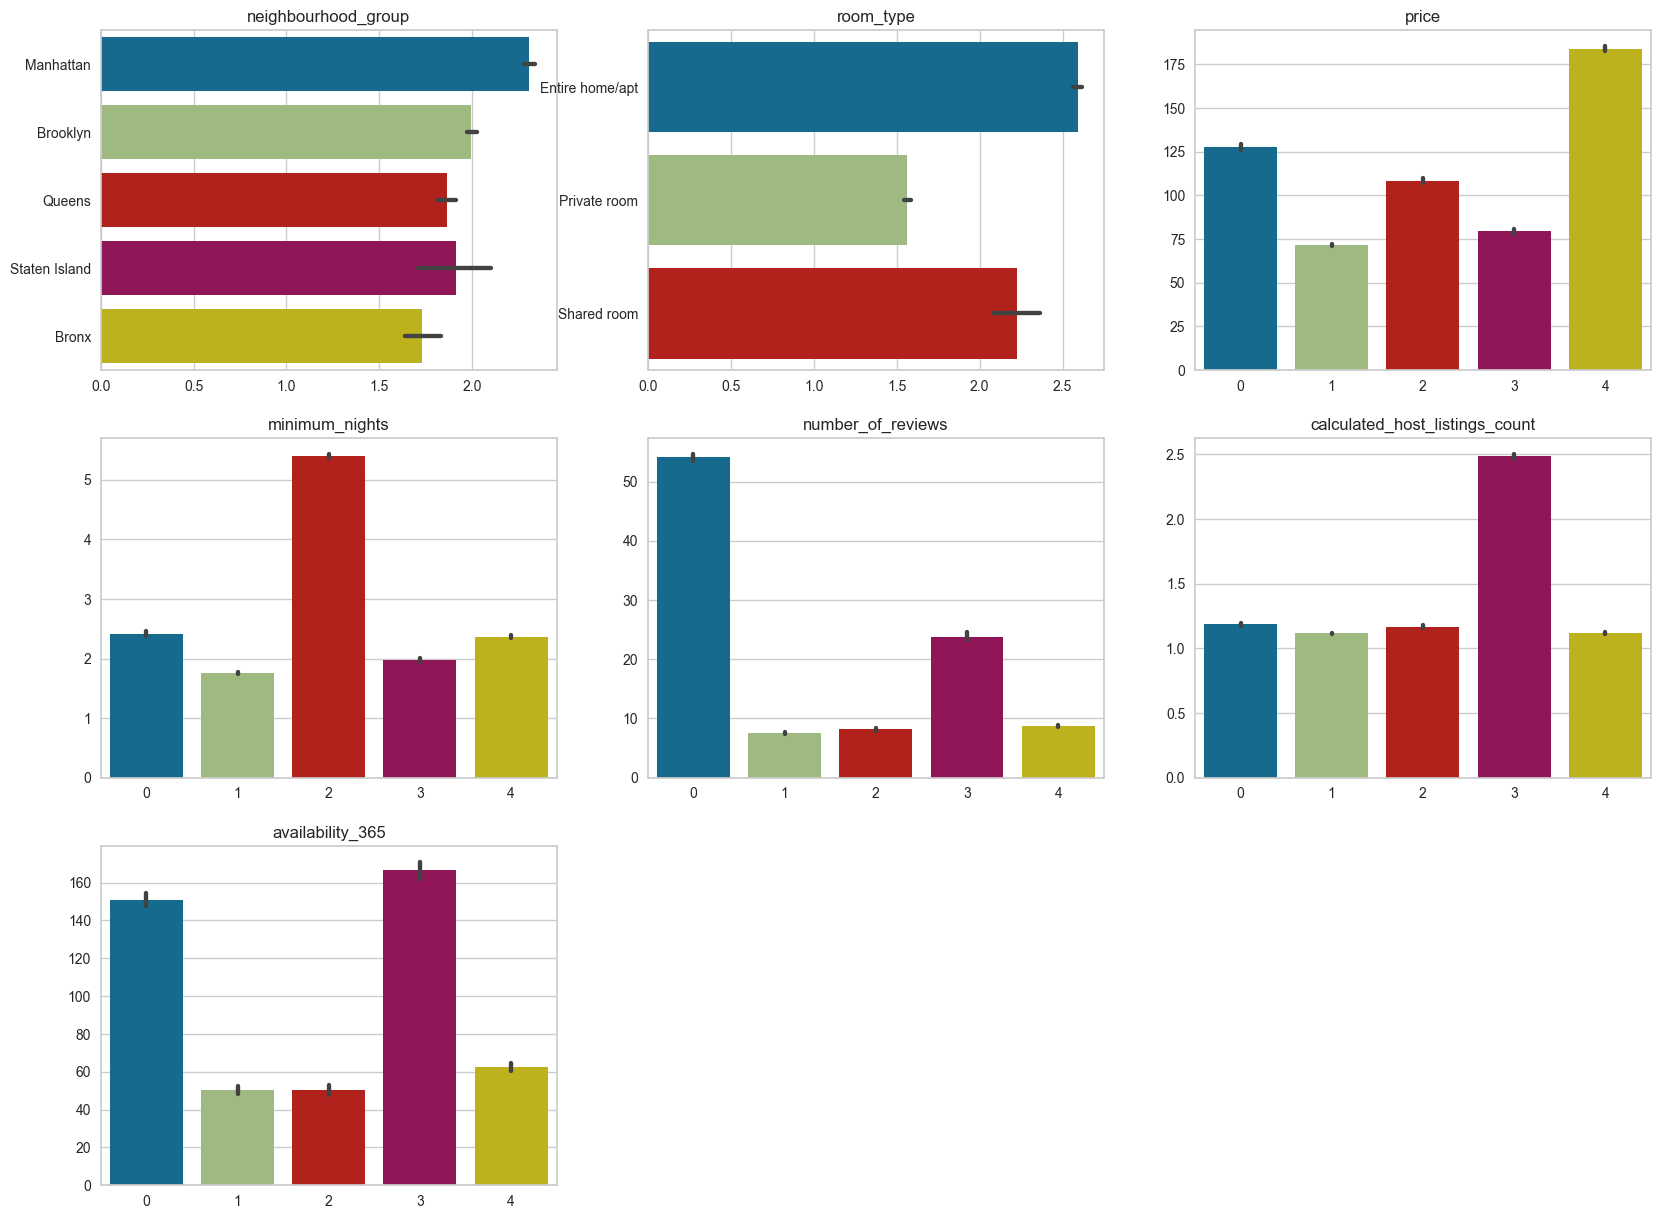

In [532]:
import math

var_list = ['neighbourhood_group','room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365' ]

cols=3

rows = math.ceil(len(var_list)/cols)

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (20, 5*rows))

for i, ax in zip(var_list, axs.flat):
    g = sns.barplot(data = df, x="clusters", y=i, ax = ax)
    ax.set(xlabel="", ylabel ="", title=i)
    
    
# Flat the plot: go backwards and drop the "ax" that is not plotting anything
for i in axs.flat[::-1][:rows*cols-len(var_list)]:
    i.set_axis_off()
    
plt.show()

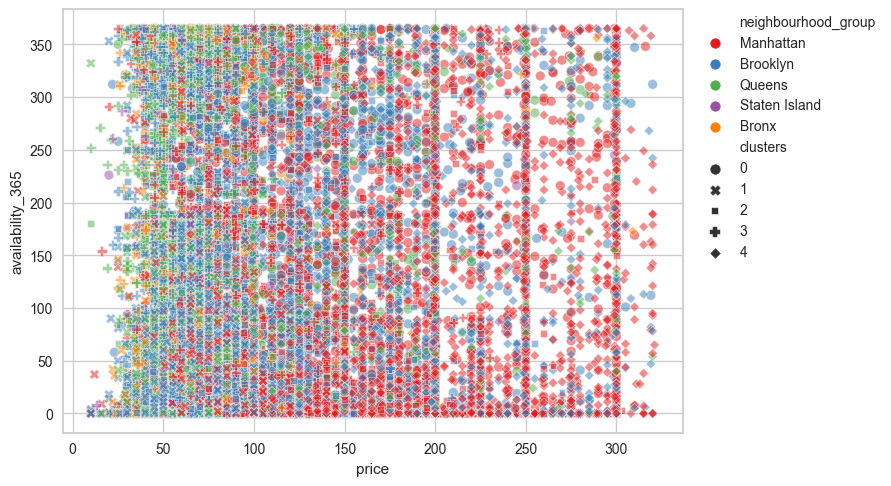

In [533]:
# Scatterplot by 5 clasters
sns.scatterplot(data = df,
            y = 'availability_365',
            x = 'price',
            hue = 'neighbourhood_group',
            style = 'clusters',
            palette='Set1',
            alpha=0.5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

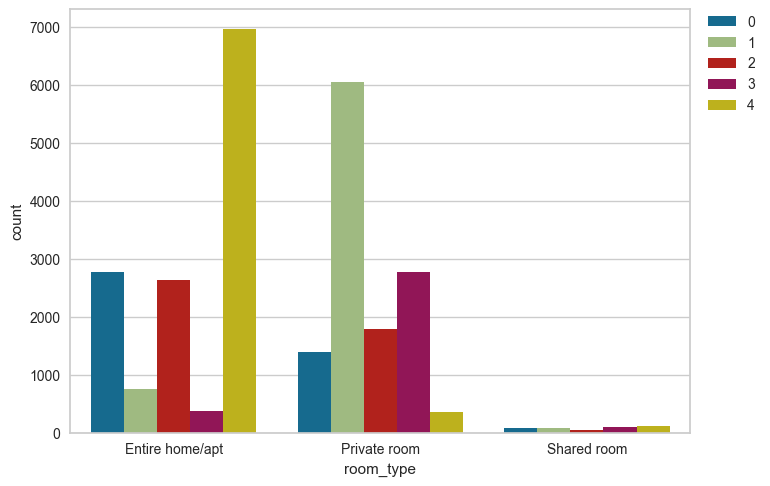

In [534]:
# Bar plot availability by neighborhood 
sns.countplot(data = df,
            x = 'room_type',
            hue = 'clusters')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

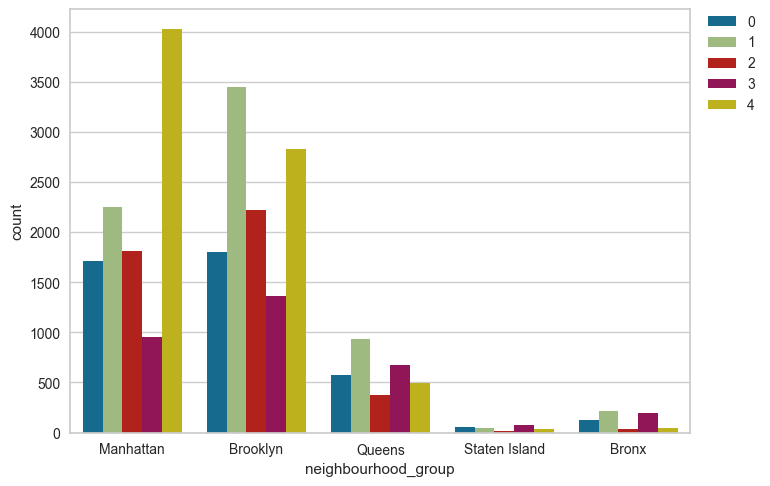

In [535]:
# Bar plot availability by neighborhood 
sns.countplot(data = df,
            x = 'neighbourhood_group',
            hue = 'clusters')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

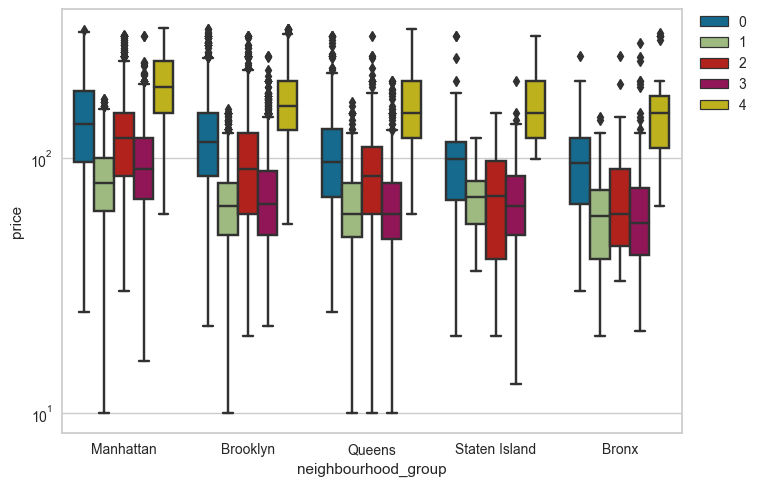

In [536]:
# Box plot availability by neighborhood 
fig = sns.boxplot(data = df,
            y = 'price',
            x = 'neighbourhood_group',
            hue = 'clusters')
fig.set_yscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

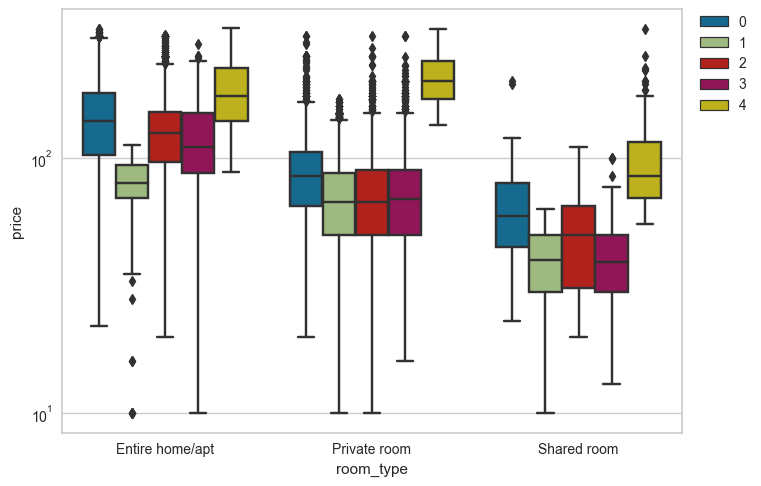

In [537]:
# Box plot by group
# Box plot availability by neighborhood 
fig = sns.boxplot(data = df,
            y = 'price',
            x = 'room_type',
            hue = 'clusters')
fig.set_yscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



In [386]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_int', 'room_type_int',
       'clusters'],
      dtype='object')

<Axes: xlabel='longitude', ylabel='latitude'>

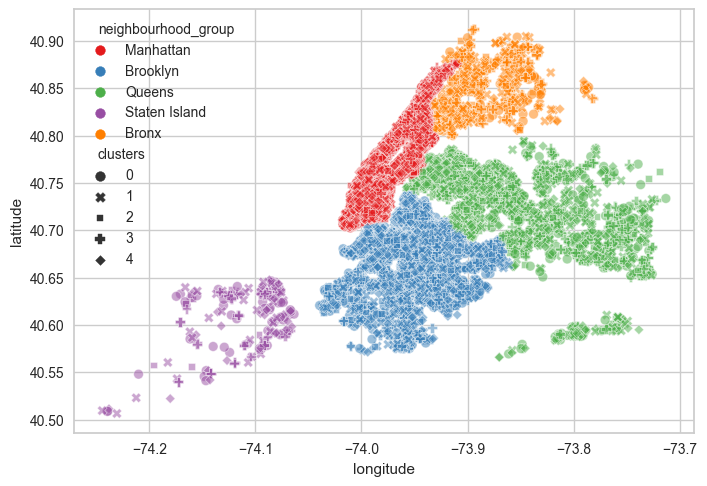

In [539]:
sns.scatterplot(data = df,
            y = 'latitude',
            x = 'longitude',
            hue = 'neighbourhood_group',
            style = 'clusters',
            palette='Set1',
            alpha=0.5)

In [756]:
import geopandas
from geodatasets import get_path
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

In [762]:
path_to_data = get_path("nybb")
gdf = geopandas.read_file(path_to_data)
gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [763]:
gdf.to_file("my_file.geojson", driver="GeoJSON") # write a GeoDataFrame

In [764]:
#Each attributes returns a Series

# Set the names of the boroughs as the index
gdf = gdf.set_index("BoroName")
# Get the boundary of each polygon
gdf["boundary"] = gdf.boundary
print(gdf["boundary"])
# Plot area
gdf["area"] = gdf.area
print(gdf["area"] )

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry
BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64


In [761]:
gdf

,BoroCode,Shape_Leng,Shape_Area,geometry,boundary,area
BoroName,,,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227....","MULTILINESTRING ((970217.022 145643.332, 97022...",1.623822e+09
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957...","MULTILINESTRING ((1029606.077 156073.814, 1029...",3.045214e+09
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100...","MULTILINESTRING ((1021176.479 151374.797, 1021...",1.937478e+09
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940....","MULTILINESTRING ((981219.056 188655.316, 98094...",6.364712e+08
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278...","MULTILINESTRING ((1012821.806 229228.265, 1012...",1.186926e+09


In [ ]:
cmap = plt.get_cmap('tab10')
gdf.plot("area", legend=False, cmap= cmap)
plt.set_axis_off();

In [770]:
gdf.explore("area", legend=False)

SystemError: initialization of _internal failed without raising an exception

Location could provide a good signal of price.



In [ ]:
pip install -U numba

# Natural Language Processing
Look at the names that homeowners gave their Airbnbs, and see how people advertise their homes using text features.

In [580]:
# Create corpus
word_lst = []

for i in df['name']:
    string = str(i).split()
    for term in string:
        word_lst.append(term.lower())
word_lst[:15]

['skylit',
 'midtown',
 'castle',
 'large',
 'cozy',
 '1',
 'br',
 'apartment',
 'in',
 'midtown',
 'east',
 'beautiful',
 '1br',
 'on',
 'upper']

In [581]:
'Skylit'.lower()

'skylit'

In [582]:
# Remove stop words
import nltk 
from nltk.corpus import stopwords
 
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [583]:
filtered_words = [word for word in word_lst if word not in stopwords.words('english')]
print(filtered_words[:30])

['skylit', 'midtown', 'castle', 'large', 'cozy', '1', 'br', 'apartment', 'midtown', 'east', 'beautiful', '1br', 'upper', 'west', 'side', 'hip', 'historic', 'brownstone', 'apartment', 'backyard', 'sweet', 'spacious', 'brooklyn', 'loft', 'maison', 'des', 'sirenes1,bohemian', 'apartment', 'sunny', 'bedroom']


In [584]:
# Count words in the list
from collections import Counter
# plotting top 25 words used by the host in naming their home
words_count = Counter(filtered_words).most_common()
words_count = words_count[:25]
# converting the data into a dataframe so we can plot it using Seaborn
words_df = pd.DataFrame(words_count)
words_df.head()

,0,1
0,room,5072
1,bedroom,4082
2,private,4075
3,apartment,3706
4,cozy,2909


In [585]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/admin/nltk_data...


True

In [586]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [587]:
sid = SentimentIntensityAnalyzer()

In [589]:
data = []
for i,row in df.iterrows():
    dic = {}
    ss = sid.polarity_scores(str(row['name']))
    
    dic['name'] = row['name']
    dic['sentiment_neu'] = ss['neu']
    dic['sentiment_pos'] = ss['pos']
    dic['sentiment_compound'] = ss['compound']
    dic['price'] = row['price']
    data.append(dic)

In [590]:
data

[{'name': 'Skylit Midtown Castle',
  'sentiment_neu': 1.0,
  'sentiment_pos': 0.0,
  'sentiment_compound': 0.0,
  'price': 225},
 {'name': 'Large Cozy 1 BR Apartment In Midtown East',
  'sentiment_neu': 1.0,
  'sentiment_pos': 0.0,
  'sentiment_compound': 0.0,
  'price': 200},
 {'name': 'Beautiful 1br on Upper West Side',
  'sentiment_neu': 0.562,
  'sentiment_pos': 0.438,
  'sentiment_compound': 0.5994,
  'price': 135},
 {'name': 'Hip Historic Brownstone Apartment with Backyard',
  'sentiment_neu': 1.0,
  'sentiment_pos': 0.0,
  'sentiment_compound': 0.0,
  'price': 99},
 {'name': 'Sweet and Spacious Brooklyn Loft',
  'sentiment_neu': 0.571,
  'sentiment_pos': 0.429,
  'sentiment_compound': 0.4588,
  'price': 299},
 {'name': 'MAISON DES SIRENES1,bohemian apartment',
  'sentiment_neu': 1.0,
  'sentiment_pos': 0.0,
  'sentiment_compound': 0.0,
  'price': 120},
 {'name': 'Sunny Bedroom Across Prospect Park',
  'sentiment_neu': 0.375,
  'sentiment_pos': 0.625,
  'sentiment_compound': 0.61

In [601]:
# building our dataframe from the data
sentiment_df = pd.DataFrame(data)
sentiment_df.head()

,name,sentiment_neu,sentiment_pos,sentiment_compound,price
0,Skylit Midtown Castle,1.000,0.000,0.0000,225
1,Large Cozy 1 BR Apartment In Midtown East,1.000,0.000,0.0000,200
2,Beautiful 1br on Upper West Side,0.562,0.438,0.5994,135
3,Hip Historic Brownstone Apartment with Backyard,1.000,0.000,0.0000,99
4,Sweet and Spacious Brooklyn Loft,0.571,0.429,0.4588,299


In [612]:
df_cluster= df[['name', 'clusters']]
df_cluster.reset_index(inplace = True)

In [613]:
df_cluster = pd.concat([sentiment_df, df_cluster], axis=1)

In [753]:
conditions = [
    df_cluster['sentiment_compound']>0,
    df_cluster['sentiment_compound']<0, 
    df_cluster['sentiment_compound']==0]

choices = ['Positive','Negative', 'Neutral']

df_cluster['col'] = np.select(conditions, choices, default=0)



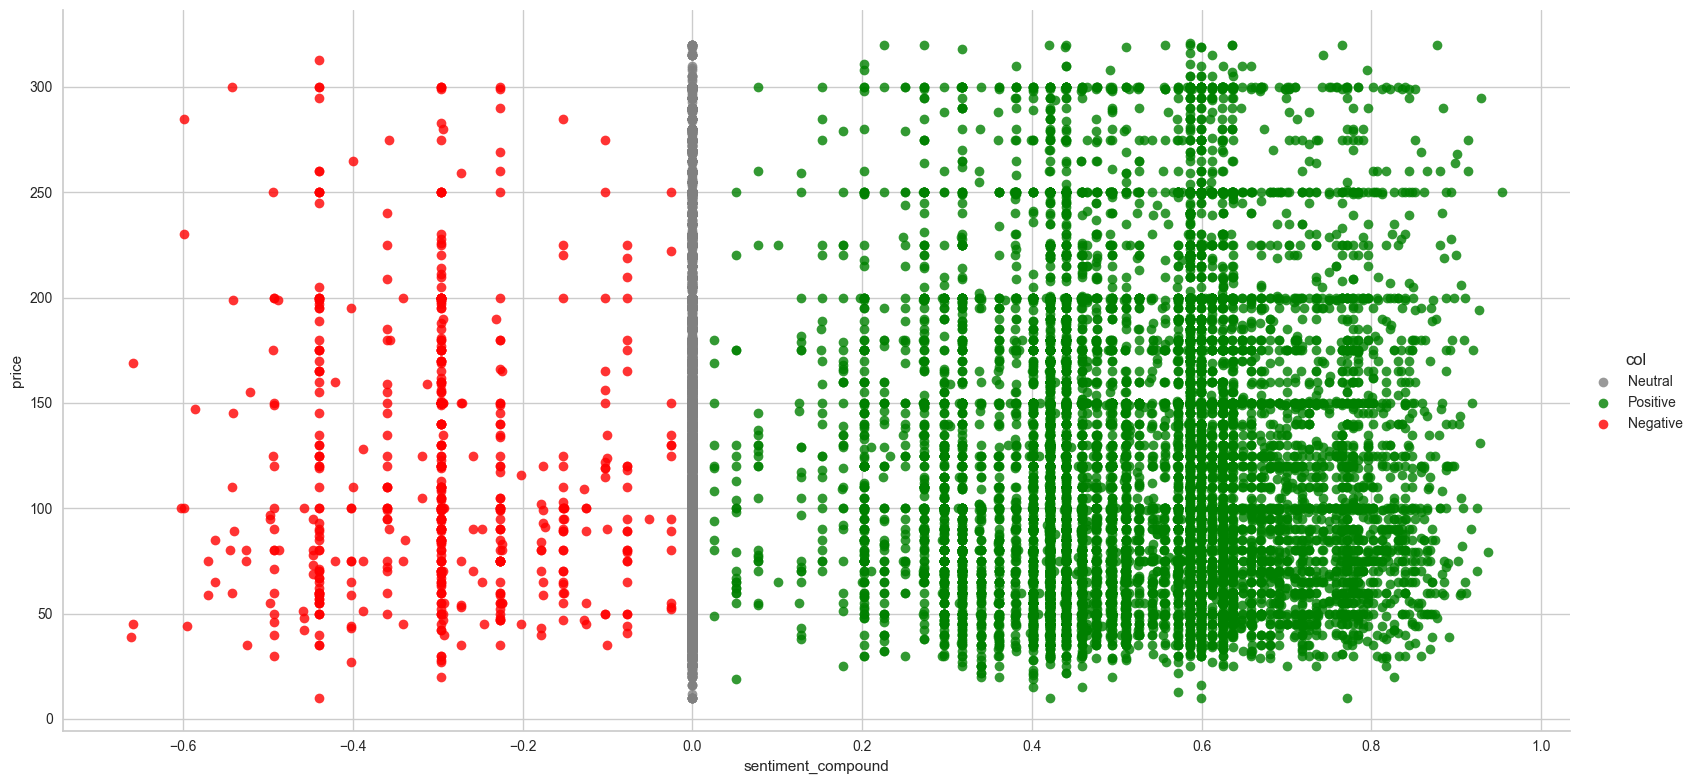

In [755]:
sns.lmplot(x='sentiment_compound', y='price', data=df_cluster, fit_reg=False, height=8, aspect=2,
          hue = 'col', palette=dict(Positive="green", Negative="red", Neutral='grey'))

In [628]:
df_cluster[df_cluster['sentiment_compound']==0].count() #14246
df_cluster[df_cluster['sentiment_compound']<0].count()  #549
df_cluster[df_cluster['sentiment_compound']>0].count()  #11470

name                  11470
sentiment_neu         11470
sentiment_pos         11470
sentiment_compound    11470
price                 11470
index                 11470
name                  11470
clusters              11470
col                   11470
dtype: int64

# Linear regression

In [712]:
df1 = df.copy()

In [713]:
df1.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_int', 'room_type_int',
       'price_transf', 'minimum_nights_transf', 'number_of_reviews_transf',
       'clusters'],
      dtype='object')

In [714]:
# drop columns 
df1.drop(columns=['id', 'name', 'host_id', 'host_name','neighbourhood', 'last_review', 'neighbourhood_group', 'room_type'], inplace = True)

df1.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
1,40.75362,-73.98377,225,1,45,0.38,2,355,2,2,5.416100,0.000000,3.806662,0
4,40.74767,-73.97500,200,3,74,0.59,1,129,2,2,5.298317,1.098612,4.304065,0
9,40.80316,-73.96545,135,5,53,0.43,1,6,2,2,4.905275,1.609438,3.970292,0
17,40.67592,-73.94694,99,3,53,4.44,1,21,1,2,4.595120,1.098612,3.970292,0
18,40.71842,-73.95718,299,3,9,0.07,1,0,1,2,5.700444,1.098612,2.197225,4


In [715]:
X = df1.select_dtypes('number'). drop("price", axis = 1)
y = df1['price']
from sklearn.model_selection import train_test_split


In [716]:
# Scale the data but not the dummie data
scaling = [col for col in X.columns if X[col].nunique() > 2 ]

In [717]:
from scipy.stats import zscore
scaled = X[scaling].apply(zscore)

In [718]:
scaled.agg(['mean', 'std']).astype(int)

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
mean,0,0,0,0,0,0,0,0,0,0,0,0,0
std,1,1,1,1,1,1,1,1,1,1,1,1,1


In [719]:
scaled

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_int,room_type_int,price_transf,minimum_nights_transf,number_of_reviews_transf,clusters
1,0.457845,-0.726732,-1.029527,1.301260,-0.543772,1.166783,2.304946,0.277697,0.858474,1.405306,-1.354722,1.283126,-1.432816
4,0.352138,-0.535173,0.196576,2.676043,-0.401706,-0.514009,0.379693,0.277697,0.858474,1.192952,0.484403,1.653069,-1.432816
9,1.337970,-0.326577,1.422678,1.680511,-0.509947,-0.514009,-0.668121,0.277697,0.858474,0.484329,1.339548,1.404825,-1.432816
17,-0.922569,0.077728,0.196576,1.680511,2.202825,-0.514009,-0.540339,-0.878671,0.858474,-0.074856,0.484403,1.404825,-1.432816
18,-0.167516,-0.145939,0.196576,-0.405367,-0.753487,-0.514009,-0.719234,-0.878671,0.858474,1.917953,0.484403,0.086107,1.292625
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38814,-0.170536,-0.866961,0.809627,-0.784617,-0.124341,-0.514009,-0.608490,0.277697,0.858474,0.674285,0.965996,-1.548079,-0.070096
38816,0.944099,-0.069054,-1.029527,-0.784617,-0.124341,-0.514009,0.533032,0.277697,-1.031003,0.402364,-1.354722,-1.548079,-0.751456
38818,-3.305516,-4.199258,-1.029527,-0.784617,-0.124341,-0.514009,0.021903,2.590433,-1.031003,1.483706,-1.354722,-1.548079,1.292625
38819,1.421648,0.578796,-1.029527,-0.737211,0.552161,-0.514009,-0.378482,3.746800,0.858474,-0.056736,-1.354722,-1.032551,-0.751456


In [725]:
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [726]:
estimator = LinearRegression()

rfe = RFE(estimator, n_features_to_select=3)
rfe = rfe.fit(scaled, y)
print("Selevted features", scaled.columns[rfe.support_])

Selevted features Index(['number_of_reviews', 'price_transf', 'clusters'], dtype='object')


In [727]:
# OLS = ordinary least squares
scaled = scaled[scaled.columns[rfe.support_]]
scaled = sm.add_constant(scaled)

In [728]:
X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2)

In [729]:
model = sm.OLS(y_train, X_train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 7.680e+04
Date:                Wed, 24 May 2023   Prob (F-statistic):               0.00
Time:                        00:57:26   Log-Likelihood:                -91640.
No. Observations:               21027   AIC:                         1.833e+05
Df Residuals:                   21023   BIC:                         1.833e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               119.7208      0.130    918.357      0.000     119.465     119.976
number_of_reviews     0.9754      0.149      6.544      0.000       0.683       1.267
price_transf         60.8734      0.147    414.863      0.000      60.586      61.161
clusters              3.8402      0.163     23.556      0.000       3.521       4.160
==============================================================================
Omnibus:                     6524.591   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19168.211
Skew:                           1.634   Prob(JB):                         0.00
Kurtosis:                       6.346   Cond. No.                         2.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [732]:
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression()

In [735]:
predicts = clf.predict(X_test)

In [751]:
d = {'predicts':predicts,'y_test':y_test}
df2 = pd.DataFrame(d)

df2.head()

,predicts,y_test
17572,115.417611,100
20845,61.097575,59
36644,107.402817,95
23870,194.638420,195
20477,157.532240,140


In [736]:
clf.score(X_test,y_test)

0.9156789562538482

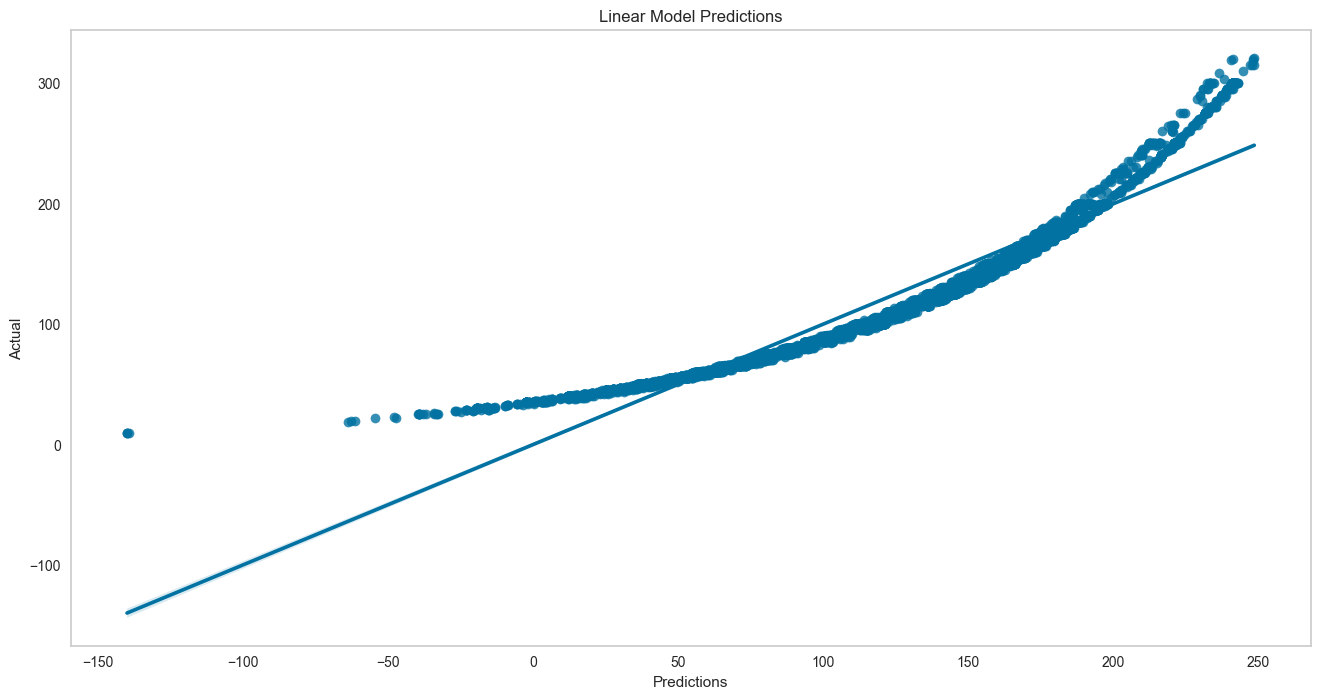

In [752]:
plt.figure(figsize=(16,8))
sns.regplot(data = df2, y='y_test',x='predicts')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()